In [1]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch


In [ ]:
data = pd.read_csv('./movie1000.csv')

data.head()

,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,http://www.dreadcentral.com/index.php?name=Rev...
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,https://www.cbr.com/city-hunter-shinjuku-priva...
3,city_hunter_shinjuku_private_eyes,2558908,2019-02-14,Matt Schley,False,2.5/5,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,https://www.japantimes.co.jp/culture/2019/02/0...
4,dangerous_men_2015,2504681,2018-08-29,Pat Padua,False,NaN,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,http://dcist.com/2015/11/out_of_frame_dangerou...


In [3]:
#select first 1000 rows from dataset
data=data.head(1000)

In [4]:
print(data.isnull().sum())

id                  0
reviewId            0
creationDate        0
criticName          0
isTopCritic         0
originalScore     332
reviewState         0
publicatioName      0
reviewText         90
scoreSentiment      0
reviewUrl         128
dtype: int64


In [5]:
relevantData = data[['reviewText','scoreSentiment']]
relevantData = relevantData.dropna(subset=['reviewText', 'scoreSentiment'])
print(data.isnull().sum())

id                  0
reviewId            0
creationDate        0
criticName          0
isTopCritic         0
originalScore     332
reviewState         0
publicatioName      0
reviewText         90
scoreSentiment      0
reviewUrl         128
dtype: int64


In [6]:
# Encode sentiment labels
sentiment_mapping = {'POSITIVE': 0, 'NEGATIVE': 1, 'NEUTRAL': 2}
relevantData['scoreSentiment'] = relevantData['scoreSentiment'].map(sentiment_mapping)


In [7]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [8]:
# Compute token lengths for each review
relevantData['token_lengths'] = relevantData['reviewText'].apply(lambda x: len(tokenizer.tokenize(x)))

In [9]:
#summary statistics
print(relevantData['token_lengths'].describe())

count    910.000000
mean      29.604396
std       13.073608
min        2.000000
25%       20.000000
50%       29.000000
75%       38.000000
max       98.000000
Name: token_lengths, dtype: float64


In [10]:
# Percentiles (90th, 95th)
print(relevantData['token_lengths'].quantile([0.9, 0.95]))

0.90    47.0
0.95    52.0
Name: token_lengths, dtype: float64


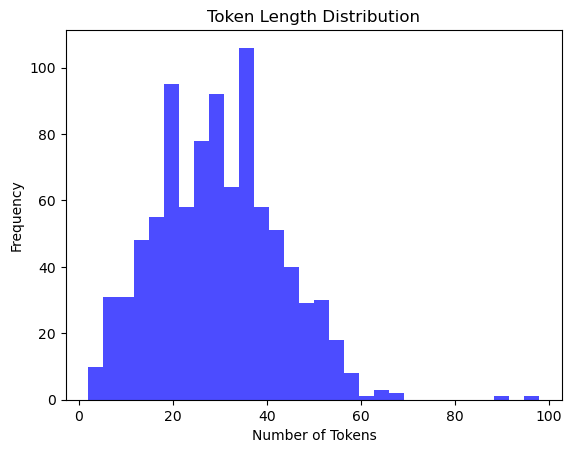

In [11]:
import matplotlib.pyplot as plt

plt.hist(relevantData['token_lengths'], bins=30, alpha=0.7, color='blue')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')
plt.show()


The analysis indicates that our tokenized reviews have the following characteristics:

Count: 910 reviews (after filtering or sampling).
Mean: On average, each review has ~30 tokens.
Median (50%): Half of the reviews are shorter than 29 tokens.
90th Percentile: 90% of reviews are shorter than 47 tokens.
95th Percentile: 95% of reviews are shorter than 52 tokens.
Max: The longest review has 98 tokens.


Given this distribution:

47 (90th percentile): Minimal truncation but efficient for most reviews.
52 (95th percentile): Covers 95% of the reviews while keeping the memory usage manageable.
98 (max): Ensures no truncation but results in significant padding for shorter reviews.
For most tasks:

We can start with max_length = 52 (covers 95% of the data with minimal information loss).
If computational efficiency is critical, max_length = 47 is also a good option.

In [12]:
#define function tekonizer for BERT model
import torch
def tokenize_function(text, tokenizer, max_length=52):
    tokens = tokenizer(
        text,
        max_length=max_length,
        truncation=True,
        padding='max_length',  # Pad to max_length
        return_tensors="pt"    # Return as PyTorch tensors
    )
    return tokens['input_ids'], tokens['attention_mask']

In [13]:
import torch
max_length = 52  # Adjust based on dataset
relevantData['input_ids'], relevantData['attention_mask'] = zip(*relevantData['reviewText'].apply(
    lambda x: tokenize_function(x, tokenizer, max_length)
))

In [14]:
relevantData.head()

,reviewText,scoreSentiment,token_lengths,input_ids,attention_mask
0,Timed to be just long enough for most youngste...,0,35,"[[tensor(101), tensor(22313), tensor(2000), te...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
1,It doesn't matter if a movie costs 300 million...,1,41,"[[tensor(101), tensor(2009), tensor(2987), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
2,The choreography is so precise and lifelike at...,0,54,"[[tensor(101), tensor(1996), tensor(16967), te...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
3,The film's out-of-touch attempts at humor may ...,1,29,"[[tensor(101), tensor(1996), tensor(2143), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
4,Its clumsy determination is endearing and some...,0,10,"[[tensor(101), tensor(2049), tensor(22902), te...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [27]:
# First, split into training + test and validation sets (80% train + 20% validation/test)
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    relevantData[['input_ids', 'attention_mask']].values,
    relevantData['scoreSentiment'].values,
    test_size=0.2,  # 80% for train + validation, 20% for test
    stratify=relevantData['scoreSentiment'],
    random_state=42
)

# Then, split the training+validation set into separate training and validation sets (80% train, 20% validation)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=0.2,  # 80% for train, 20% for validation
    stratify=train_val_labels,
    random_state=42
)


In [30]:
# Ensure that train_texts, val_texts, and test_texts are tensors or NumPy arrays
train_inputs = torch.stack([item[0] for item in train_texts], dim=0).long()  # stack tensors to create a single tensor
train_masks = torch.stack([item[1] for item in train_texts], dim=0).long()   # stack attention_masks
train_labels = torch.tensor(train_labels, dtype=torch.long)

val_inputs = torch.stack([item[0] for item in val_texts], dim=0).long()
val_masks = torch.stack([item[1] for item in val_texts], dim=0).long()
val_labels = torch.tensor(val_labels, dtype=torch.long)

test_inputs = torch.stack([item[0] for item in test_texts], dim=0).long()
test_masks = torch.stack([item[1] for item in test_texts], dim=0).long()
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create DataLoader objects
batch_size = 16
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Save the datasets (train, validation, and test)
torch.save(train_data, 'train_data.pt')
torch.save(val_data, 'val_data.pt')
torch.save(test_data, 'test_data.pt')
